In [7]:
from typing import Tuple

import numpy as np
from sklearn.base import ClassifierMixin
from sklearn.metrics import roc_auc_score


def roc_auc_ci(
    classifier: ClassifierMixin,
    X: np.ndarray,
    y: np.ndarray,
    #conf : уровень доверия (например 0.95 → 95 % ДИ)
    conf: float = 0.95,
    n_bootstraps: int = 10_000,
    seed: int = 42,
) -> Tuple[float, float]:
    """Returns confidence bounds of the ROC-AUC"""
    if not (0.0 < conf < 1.0):
      raise ValueError("\conf\ must be between 0 and 1")
    #y_score содержит предсказанные вероятности для класса 1 --> Вероятность принадлежности к каждому классу	[0.15, 0.85], [0.9, 0.1]
    if hasattr(classifier,"predict_proba"):
      y_score = classifier.predict_proba(X)[:,1]
    ##Этот метод возвращает расстояние от каждого наблюдения до разделяющей гиперплоскости. Чем больше это число (чем дальше объект от границы), тем увереннее модель в своем предсказании.
    # -2.5, 0.3, 5.1
    if hasattr(classifier,"decision_function"):
      y_score = classifier.decision_function(X)
    else:
      y_score = classifier.predict(X)


    #rng - задает (Создает генератор случайных чисел с фиксированным seed для обеспечения воспроизводимости результатов)
    rng = np.random.default_rng(seed)
    n_objects = len(y)

    aucs = np.empty(n_bootstraps,dtype = float)
    collected = 0

    while collected < n_bootstraps:
      #создаем новую выборку того же размера, что и исходная, случайно выбирая объекты с повторениями
      idx = rng.integers(0,n_objects,size = n_objects)

      if len(np.unique(y[idx])) < 2:
        continue
      aucs[collected] = roc_auc_score(y[idx],y_score[idx])
      collected += 1

    alpha = 1.0 - conf
    lcb = np.quantile(aucs, alpha / 2)
    ucb = np.quantile(aucs, 1.0 - alpha / 2)
    return (lcb, ucb)

<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipython-input-1298403922.py:19: SyntaxWarning: invalid escape sequence '\c'
  raise ValueError("\conf\ must be between 0 and 1")


С уверенностью в 95% мы можем утверждать, что истинное значение ROC-AUC нашей модели лежит в диапазоне между 0.82 и 0.90

In [8]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np

X, y = make_classification(
    n_samples=3000, n_features=20, n_informative=5,
    n_redundant=2, random_state=0
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
clf = LogisticRegression(max_iter=1000, solver="lbfgs")
clf.fit(X_train, y_train)

y_score = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_score)
print(f"ROC-AUC = {auc:.3f}")

lcb, ucb = roc_auc_ci(clf, X_test, y_test, conf=0.95, n_bootstraps=2000)
print(f"95 % CI for ROC-AUC: [{lcb:.3f}, {ucb:.3f}]")

ROC-AUC = 0.936
95 % CI for ROC-AUC: [0.920, 0.952]


**ROC-AUC сообщает, насколько хорошо классы разделимы между собой обученной моделью.** Однако нет гарантии, что полученные вероятности хорошо откалиброваны, **ведь ROC-AUC обращает внимание только на ранги вероятностей, а не их реальные значения, тем более их распределение.**

In [2]:
from typing import Tuple

import numpy as np


def pr_threshold(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    min_precision: float,
) -> Tuple[float, float]:
    """Returns threshold and recall (from Precision-Recall Curve)"""
    # Получаем все уникальные пороги, отсортированные по убыванию (как y_prob)
    thresholds = np.unique(y_prob)[::-1]
    # Добавляем крайние значения для полного покрытия
    thresholds = np.append(thresholds, 0.0)
    thresholds = np.insert(thresholds, 0, 1.0)

    best_recall = -1.0
    best_threshold = 1.0  # Начинаем с самого строгого порога

    for thresh in thresholds:
        y_pred = (y_prob >= thresh).astype(int)
        # Вычисляем TP, FP, FN для вычисления Precision и Recall
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))

        # Избегаем деления на ноль
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        # Проверяем условие: Precision >= min_precision
        if precision >= min_precision:
            # Если нашли порог с бОльшим Recall или тот же Recall, но с бОльшим порогом
            if recall > best_recall or (np.isclose(recall, best_recall) and thresh > best_threshold):
                best_recall = recall
                best_threshold = thresh

    return best_threshold, best_recall

def sr_threshold(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    min_specificity: float,
) -> Tuple[float, float]:
    """Returns threshold and recall (from Specificity-Recall Curve)"""
    thresholds = np.unique(y_prob)[::-1]
    thresholds = np.append(thresholds, 0.0)
    thresholds = np.insert(thresholds, 0, 1.0)

    best_recall = -1.0
    best_threshold = 1.0

    for thresh in thresholds:
        y_pred = (y_prob >= thresh).astype(int)
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fn = np.sum((y_pred == 0) & (y_true == 1))
        tn = np.sum((y_pred == 0) & (y_true == 0))
        fp = np.sum((y_pred == 1) & (y_true == 0))

        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        if specificity >= min_specificity:
            if recall > best_recall or (np.isclose(recall, best_recall) and thresh > best_threshold):
                best_recall = recall
                best_threshold = thresh

    return best_threshold, best_recall

def pr_curve(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    conf: float = 0.95,
    n_bootstrap: int = 10_000,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Returns Precision-Recall curve and it's (LCB, UCB)"""
    thresholds = np.unique(y_prob)[::-1]
    thresholds = np.append(thresholds, 0.0)
    thresholds = np.insert(thresholds, 0, 1.0 + 1e-10)  # Порог выше максимума

    n_points = len(thresholds)
    recall = np.zeros(n_points)
    precision = np.zeros(n_points)
    for i, thresh in enumerate(thresholds):
        y_pred = (y_prob >= thresh).astype(int)
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))

        precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    rng = np.random.default_rng(42)
    n_objects = len(y_true)
    bootstrap_precisions = np.zeros((n_bootstrap, n_points))

    collected = 0
    while collected < n_bootstrap:
        idx = rng.integers(0, n_objects, size=n_objects)
        y_true_bs = y_true[idx]
        y_prob_bs = y_prob[idx]

        if len(np.unique(y_true_bs)) < 2:
            continue
        for j, thresh in enumerate(thresholds):
            y_pred_bs = (y_prob_bs >= thresh).astype(int)
            tp_bs = np.sum((y_pred_bs == 1) & (y_true_bs == 1))
            fp_bs = np.sum((y_pred_bs == 1) & (y_true_bs == 0))
            precision_bs = tp_bs / (tp_bs + fp_bs) if (tp_bs + fp_bs) > 0 else 0.0
            bootstrap_precisions[collected, j] = precision_bs

        collected += 1
    alpha = 1.0 - conf
    precision_lcb = np.quantile(bootstrap_precisions, alpha / 2, axis=0)
    precision_ucb = np.quantile(bootstrap_precisions, 1.0 - alpha / 2, axis=0)

    return recall, precision, precision_lcb, precision_ucb

def sr_curve(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    conf: float = 0.95,
    n_bootstrap: int = 10_000,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Returns Specificity-Recall curve and it's (LCB, UCB)"""
    # 1. Строим исходную кривую
    thresholds = np.unique(y_prob)[::-1]
    thresholds = np.append(thresholds, 0.0)
    thresholds = np.insert(thresholds, 0, 1.0 + 1e-10)

    n_points = len(thresholds)
    recall = np.zeros(n_points)
    specificity = np.zeros(n_points)

    for i, thresh in enumerate(thresholds):
        y_pred = (y_prob >= thresh).astype(int)
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fn = np.sum((y_pred == 0) & (y_true == 1))
        tn = np.sum((y_pred == 0) & (y_true == 0))
        fp = np.sum((y_pred == 1) & (y_true == 0))

        recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        specificity[i] = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    rng = np.random.default_rng(42)
    n_objects = len(y_true)
    bootstrap_specificities = np.zeros((n_bootstrap, n_points))

    collected = 0
    while collected < n_bootstrap:
        idx = rng.integers(0, n_objects, size=n_objects)
        y_true_bs = y_true[idx]
        y_prob_bs = y_prob[idx]

        if len(np.unique(y_true_bs)) < 2:
            continue

        for j, thresh in enumerate(thresholds):
            y_pred_bs = (y_prob_bs >= thresh).astype(int)
            tn_bs = np.sum((y_pred_bs == 0) & (y_true_bs == 0))
            fp_bs = np.sum((y_pred_bs == 1) & (y_true_bs == 0))
            specificity_bs = tn_bs / (tn_bs + fp_bs) if (tn_bs + fp_bs) > 0 else 0.0
            bootstrap_specificities[collected, j] = specificity_bs

        collected += 1
    alpha = 1.0 - conf
    specificity_lcb = np.quantile(bootstrap_specificities, alpha / 2, axis=0)
    specificity_ucb = np.quantile(bootstrap_specificities, 1.0 - alpha / 2, axis=0)

    return recall, specificity, specificity_lcb, specificity_ucb

In [8]:
from typing import Tuple

import numpy as np

def _basic_curves(
    y_true: np.ndarray,
    y_prob: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Builds  (recall, precision, specificity) arrays of length N + 1
    Assumes y_prob is already sorted in DESCENDING order
    """
    if y_true.ndim != 1 or y_prob.ndim != 1:
        raise ValueError("y_true and y_prob must be 1-D arrays")
    if len(y_true) != len(y_prob):
        raise ValueError("y_true and y_prob must be of equal length")

    y_true = y_true.astype(int)
    n_objects = len(y_true)
    n_pos = y_true.sum()
    n_neg = n_objects - n_pos
    if n_pos == 0 or n_neg == 0:
        raise ValueError("Both positive and negative objects must be present")

    tp_cum = np.cumsum(y_true)                   # length N
    fp_cum = np.arange(1, n_objects + 1) - tp_cum

    # allocate result (N + 1)
    recall = np.empty(n_objects + 1, dtype=float)
    precision = np.empty_like(recall)
    specificity = np.empty_like(recall)

    # threshold that predicts NOTHING positive
    recall[0] = 0.0
    precision[0] = 1.0           # by convention
    specificity[0] = 1.0

    # thresholds after we mark first k objects positive
    idx = np.arange(1, n_objects + 1)
    recall[idx] = tp_cum / n_pos
    precision[idx] = tp_cum / idx
    specificity[idx] = (n_neg - fp_cum) / n_neg

    return recall, precision, specificity


def _step_interpolate(x_grid: np.ndarray, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Step-wise (left-constant) interpolation:
    takes y corresponding to the last x <= x_grid[i]
    Assumes x is sorted ASCENDING and starts with 0.
    """
    idx = np.searchsorted(x, x_grid, side="right") - 1
    idx[idx < 0] = 0                # for possible round-off at 0
    return y[idx]


def _bootstrap_bounds(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    recall_grid: np.ndarray,
    conf: float,
    n_bootstrap: int,
    metric: str = "precision",      # or "specificity"
    seed: int = 42,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Builds bootstrap LCB / UCB for metric(recall)
    metric : either "precision" or "specificity"
    """
    rng = np.random.default_rng(seed)
    alpha = 1.0 - conf
    collected = 0
    boot_values = np.empty((n_bootstrap, len(recall_grid)), dtype=float)

    while collected < n_bootstrap:
        idx = rng.integers(0, len(y_true), size=len(y_true))
        y_t = y_true[idx]
        y_p = y_prob[idx]

        # need y_p sorted descending
        order = np.argsort(-y_p)
        y_t = y_t[order]
        y_p = y_p[order]

        # skip degenerate bootstrap that has ≤1 class
        if y_t.sum() == 0 or y_t.sum() == len(y_t):
            continue

        rec_b, prec_b, spec_b = _basic_curves(y_t, y_p)
        y_b = prec_b if metric == "precision" else spec_b
        # put on the grid
        boot_values[collected] = _step_interpolate(recall_grid, rec_b, y_b)
        collected += 1

    lcb = np.quantile(boot_values, alpha / 2, axis=0)
    ucb = np.quantile(boot_values, 1.0 - alpha / 2, axis=0)
    return lcb, ucb

def pr_threshold(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    min_precision: float,
) -> Tuple[float, float]:
    """
    Finds a probability threshold that gives the MAXIMUM recall while
    keeping precision ≥ min_precision.
    If several thresholds give the same recall,   takes the HIGHEST
    probability threshold (i.e. the earliest in sorted order).
    Returns (threshold_probability, recall_at_threshold)
    """
    recall, precision, _ = _basic_curves(y_true, y_prob)
    candidates = np.where(precision[1:] >= min_precision)[0] + 1
    if len(candidates) == 0:
        return np.nan, 0.0

    best_recall = recall[candidates].max()
    best_idxs = candidates[recall[candidates] == best_recall]

    best_idx = best_idxs.min()
    threshold_proba = y_prob[best_idx - 1]
    return float(threshold_proba), float(best_recall)


def sr_threshold(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    min_specificity: float,
) -> Tuple[float, float]:
    """
    Same as pr_threshold, but works on Specificity-Recall curve
    (x-axis: recall / sensitivity, y-axis: specificity).
    """
    recall, _, specificity = _basic_curves(y_true, y_prob)
    candidates = np.where(specificity[1:] >= min_specificity)[0] + 1
    if len(candidates) == 0:
        return np.nan, 0.0

    best_recall = recall[candidates].max()
    best_idxs = candidates[recall[candidates] == best_recall]
    best_idx = best_idxs.min()
    threshold_proba = y_prob[best_idx - 1]
    return float(threshold_proba), float(best_recall)


def pr_curve(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    conf: float = 0.95,
    n_bootstrap: int = 10_000,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Returns
        recall            – (N + 1,)
        precision         – (N + 1,)
        precision_lcb     – (N + 1,)
        precision_ucb     – (N + 1,)
    All share the same recall axis.
    """
    recall, precision, _ = _basic_curves(y_true, y_prob)
    lcb, ucb = _bootstrap_bounds(
        y_true, y_prob, recall, conf, n_bootstrap, metric="precision"
    )
    return recall, precision, lcb, ucb


def sr_curve(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    conf: float = 0.95,
    n_bootstrap: int = 10_000,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Returns
        recall            – (N + 1,)
        specificity       – (N + 1,)
        specificity_lcb   – (N + 1,)
        specificity_ucb   – (N + 1,)
    """
    recall, _, specificity = _basic_curves(y_true, y_prob)
    lcb, ucb = _bootstrap_bounds(
        y_true, y_prob, recall, conf, n_bootstrap, metric="specificity"
    )
    return recall, specificity, lcb, ucb

In [9]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    weights=[0.8, 0.2],
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]

sort_idx = np.argsort(y_prob)[::-1]
y_prob_sorted = y_prob[sort_idx]
y_test_sorted = y_test[sort_idx]

print(f"Размер тестовой выборки: {len(y_test_sorted)}")
print(f"Баланс классов: {np.bincount(y_test_sorted)}")

Размер тестовой выборки: 300
Баланс классов: [243  57]


In [10]:
min_precision = 0.7
threshold, recall = pr_threshold(y_test_sorted, y_prob_sorted, min_precision)
# Когда важно обеспечить минимальный уровень точности предсказаний. Например, в спам-фильтрах, где ложные срабатывания дорого обходятся.
print("\n=== pr_threshold ===")
print(f"Минимальная точность: {min_precision}")
print(f"Найденный порог: {threshold:.4f}")
print(f"Recall при этом пороге: {recall:.4f}")

y_pred = (y_prob_sorted >= threshold).astype(int)
tp = np.sum((y_pred == 1) & (y_test_sorted == 1))
fp = np.sum((y_pred == 1) & (y_test_sorted == 0))
actual_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
print(f"Фактическая precision: {actual_precision:.4f}")


=== pr_threshold ===
Минимальная точность: 0.7
Найденный порог: 0.3200
Recall при этом пороге: 0.8070
Фактическая precision: 0.7077


In [11]:
# Тестируем sr_threshold
min_specificity = 0.8  # хотим минимум 80% специфичности
threshold, recall = sr_threshold(y_test_sorted, y_prob_sorted, min_specificity)
#Когда важно правильно идентифицировать отрицательные классы. Например, в медицинской диагностике, где важно не пропустить здоровых пациентов.
print("\n=== sr_threshold ===")
print(f"Минимальная специфичность: {min_specificity}")
print(f"Найденный порог: {threshold:.4f}")
print(f"Recall при этом пороге: {recall:.4f}")

# Проверим вручную
y_pred = (y_prob_sorted >= threshold).astype(int)
tn = np.sum((y_pred == 0) & (y_test_sorted == 0))
fp = np.sum((y_pred == 1) & (y_test_sorted == 0))
actual_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
print(f"Фактическая specificity: {actual_specificity:.4f}")


=== sr_threshold ===
Минимальная специфичность: 0.8
Найденный порог: 0.2200
Recall при этом пороге: 0.9123
Фактическая specificity: 0.8107



=== pr_curve ===
Количество точек на кривой: 301
Recall range: [0.0000, 1.0000]
Precision range: [0.1900, 1.0000]


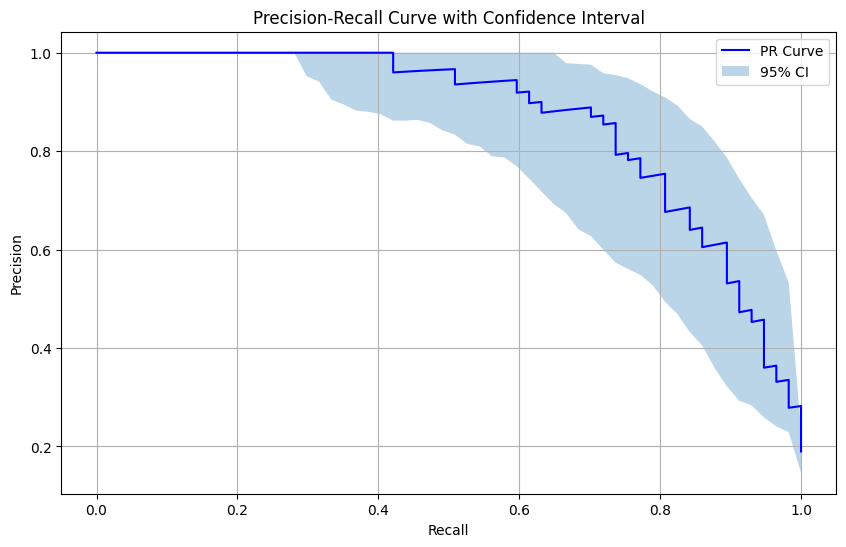

In [12]:
# Тестируем pr_curve (уменьшим n_bootstrap для скорости)
recall, precision, precision_lcb, precision_ucb = pr_curve(
    y_test_sorted, y_prob_sorted, conf=0.95, n_bootstrap=1000
)
#Для анализа компромисса между точностью и полнотой, особенно на несбалансированных данных. Доверительный интервал показывает устойчивость метрик.
print("\n=== pr_curve ===")
print(f"Количество точек на кривой: {len(recall)}")
print(f"Recall range: [{recall.min():.4f}, {recall.max():.4f}]")
print(f"Precision range: [{precision.min():.4f}, {precision.max():.4f}]")

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, 'b-', label='PR Curve')
plt.fill_between(recall, precision_lcb, precision_ucb, alpha=0.3, label='95% CI')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Confidence Interval')
plt.legend()
plt.grid(True)
plt.show()

1. Коротко: модель ранжирует **объекты неплохо, но по мере стремления к полному охвату резко растёт число ложных срабатываний.**

Что видно по кривой PR и доверительному интервалу:
- При малой полноте (recall до ~0.4–0.5) точность почти 1.0: верхние по скору объекты почти всегда правильные.
- По мере роста полноты точность убывает; после recall ~0.7–0.8 она падает ниже ~0.8 и к recall ~1.0 опускается до ~0.25–0.35. Значит, **за высокий охват приходится платить большим числом FP.**
- Доверительный интервал узкий при recall ≤ ~0.6 (оценка стабильнее) и заметно расширяется при высоком recall (больше неопределённости).
- Практический выбор порога:
  - если нужна точность ≥0.9 — придётся ограничиться recall около ~0.5–0.6;
  - для компромисса precision ~0.8 — ориентируйтесь на recall ~0.7–0.75;
  - при recall >0.9 точность будет около ~0.5, что приемлемо только если критичен максимум найденных положительных.
- Для полной оценки полезно знать долю положительного класса (baseline precision); AUPRC должно быть заметно выше этой доли, чтобы говорить о хорошей модели.

Итог: **модель очень точна для топ-N предсказаний, но нестабильна и менее точна при попытке охватить почти все положительные примеры.**


=== sr_curve ===
Количество точек на кривой: 301
Recall range: [0.0000, 1.0000]
Specificity range: [0.0000, 1.0000]


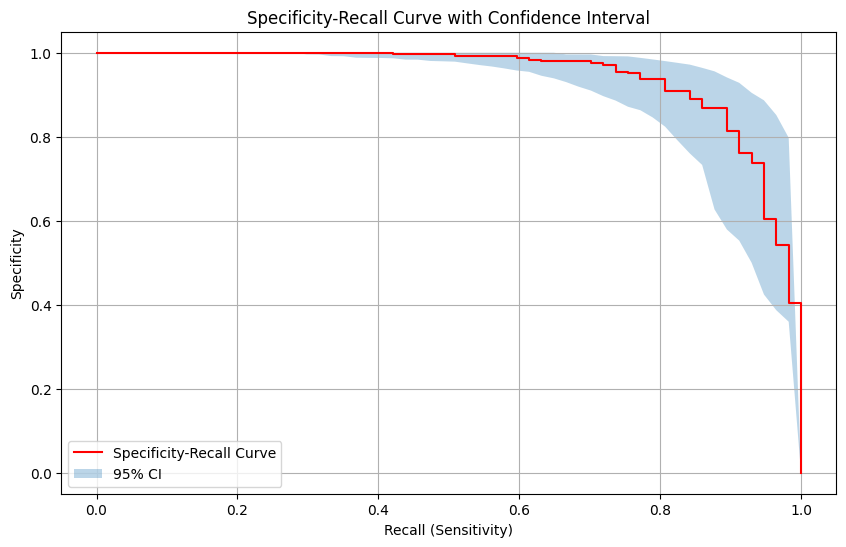

In [13]:
recall, specificity, specificity_lcb, specificity_ucb = sr_curve(
    y_test_sorted, y_prob_sorted, conf=0.95, n_bootstrap=1000
)

print("\n=== sr_curve ===")
print(f"Количество точек на кривой: {len(recall)}")
print(f"Recall range: [{recall.min():.4f}, {recall.max():.4f}]")
print(f"Specificity range: [{specificity.min():.4f}, {specificity.max():.4f}]")

plt.figure(figsize=(10, 6))
plt.plot(recall, specificity, 'r-', label='Specificity-Recall Curve')
plt.fill_between(recall, specificity_lcb, specificity_ucb, alpha=0.3, label='95% CI')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Specificity')
plt.title('Specificity-Recall Curve with Confidence Interval')
plt.legend()
plt.grid(True)
plt.show()

«Из всех настоящих положительных объектов какую долю модель действительно нашла» - Sensitivity - TP / (TP + FN)

«Из всех настоящих отрицательных объектов какую долю модель правильно отвергла?» - Specificity - TN / (TN + FP)

**Коротко: модель в целом сильная, но есть выраженный компромисс между чувствительностью и специфичностью.**

Что видно по кривой:
- При умеренной чувствительности (recall ≈0.5–0.7) специфичность почти максимальная (≈0.97–1.0). То есть мало ложноположительных при заметном числе пропусков.
- По мере роста чувствительности выше ≈0.8 специфичность начинает заметно падать: около recall ≈0.9 она уже ~0.8, а при стремлении к 1.0 может опускаться до ~0.4 и ниже. Идеально «и то и другое» недостижимо.
- Доверительный интервал узкий при небольших/средних значениях recall (оценки стабильны) и сильно расширяется при высоких (оценки специфичности там менее надёжны).

Практический вывод:
- Если важнее избежать ложноположительных, держите порог так, чтобы recall был ~0.6–0.7 (специфичность ≈0.97+).
- Если приоритет — не пропускать положительные, выбирайте recall ~0.85–0.9, принимая специфичность порядка ~0.8.
- Для выбора порога рассчитайте метрику вроде Youden’s J (recall + specificity − 1) или минимизируйте стоимость ошибок с учётом бизнес-цен.